In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'lines.markersize': 10})

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.stats import iqr

from copy import deepcopy

import divebomb

import time
import pickle

import importlib

np.random.seed(0)

import Preprocessor
import Parameters
import HHMM
import Visualisor

# Load in the HMMs

In [108]:
#model = 'hhmm_FV'
#model = 'hhmm_FV_uncorr'
model = 'hhmm_V'
#model = 'hmm_FV'

hhmms = []
for dataset_num in range(1,501):
    try:
        file = '../Params/%s_%d_%d'%(model,0,dataset_num)
        with open(file, 'rb') as f:
            hhmm = pickle.load(f)
            A = hhmm.SEs
            if A is None:
                print(file)
        hhmms.append(hhmm)
    except:
        print('../Params/%s_%d_%d'%(model,0,dataset_num))

../Params/hhmm_V_0_83
../Params/hhmm_V_0_90


(array([  4.,  22.,  50., 127., 112.,  95.,  61.,  21.,   5.,   1.]),
 array([0.35 , 0.383, 0.416, 0.449, 0.482, 0.515, 0.548, 0.581, 0.614,
        0.647, 0.68 ]),
 <a list of 10 Patch objects>)

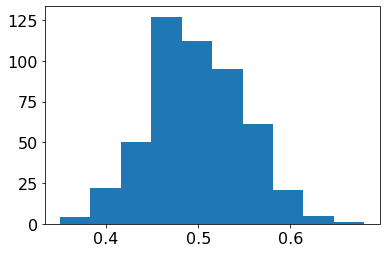

In [109]:
props = []
for hhmm in hhmms:
    props.append(np.mean([x['dive_type'] for x in hhmm.data]))
plt.hist(props)

# Plot Empirical distribtuion
 - Compare with Fischer SEs

In [110]:
def make_2d_kde_theta(feature,theta0,hhmms,dive_type,N,include_corr=False,feature_name=''):
    
    # get mu and sigma and corr
    if dive_type == -1:
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[0][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    else:
        mus = np.array([hhmm.theta[1][dive_type][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][dive_type][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[1][dive_type][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    # get a 2-D histogram of these guys
    for i in range(N):

        xlim = [np.mean(mus[:,i])-3*np.std(mus[:,i]),np.mean(mus[:,i])+3*np.std(mus[:,i])]
        ylim = [np.mean(sigs[:,i])-3*np.std(sigs[:,i]),np.mean(sigs[:,i])+3*np.std(sigs[:,i])]
        zlim = [np.mean(corrs[:,i])-3*np.std(corrs[:,i]),np.mean(corrs[:,i])+3*np.std(corrs[:,i])]
        
        if theta0:
            xlim[0] = min(xlim[0],theta0['mu'][i])
            xlim[1] = max(xlim[1],theta0['mu'][i])
            ylim[0] = min(ylim[0],theta0['sig'][i])
            ylim[1] = max(ylim[1],theta0['sig'][i])
            zlim[0] = min(zlim[0],theta0['corr'][i])
            zlim[1] = max(zlim[1],theta0['corr'][i])
        
        if include_corr:
            fig, axs = plt.subplots(2,2,figsize = (10,10))

            plt.subplot(2,2,1)
            kernel = gaussian_kde([mus[:,i],corrs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,zlim[0]:zlim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + zlim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['corr'][i],'r*')
            c = plt.colorbar()
            c.set_label('Probability Density',fontsize = 16)
            plt.xticks([])
            plt.ylabel(r'$\hat \phi$')
            if dive_type == -1:
                plt.title(r'P($\hat \theta^{(%d)}$), %s' % (i+1,feature_name))
            else:
                plt.title(r'P($\hat \theta^{*(\cdot,%d)}$), %s' % (i+1,feature_name))

            fig.delaxes(axs[0,1])

            plt.subplot(2,2,3)
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            plt.xlabel(r'$\hat \mu$')
            plt.ylabel(r'$\hat \sigma$')
            
            plt.subplot(2,2,4)
            kernel = gaussian_kde([corrs[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[zlim[0]:zlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = zlim + ylim, aspect='auto')
            plt.plot(theta0['corr'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            c.set_label('Probability Density',fontsize = 16)
            plt.xlabel(r'$\hat \phi$')
            plt.yticks([])

            
        else:
            
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            c.set_label('Probability Density',fontsize = 16)
            plt.xlabel(r'$\hat \mu$',fontsize=16)
            plt.ylabel(r'$\hat \sigma$')
            if dive_type == -1:
                plt.title(r'P($\hat \theta^{(%d)}$), %s' % (i+1,feature_name))
            else:
                plt.title(r'P($\hat \theta^{*(\cdot,%d)}$), %s' % (i+1,feature_name))
        
        plt.tight_layout()
        plt.savefig('../Plots/%s_MLE_density_%s_%d_%d'%(model,feature,dive_type,i))
        plt.show()
        
    print(r'$\hat \mu$ sample mean:', np.mean(mus,0))
    print('Bias:', np.mean(mus,0) - np.array(theta0['mu']))
    print('Empirical Standard Error:', np.std(mus,0))
    print('Fischer Standard Error:',np.nanmedian(mus_SE,0))
    print('pm:',np.std(mus_SE,0))
    print('')

    print(r'$\sigma$ sample mean:', np.mean(sigs,0))
    print('Bias:', np.mean(sigs,0) - np.array(theta0['sig']))
    print('Empirical Standard Error:', np.std(sigs,0))
    print('Fischer Standard Error:',np.nanmedian(sigs_SE,0))
    print('pm:',np.std(sigs_SE,0))
    print('')

    if include_corr:
        print(r'$\rho$ sample mean:', np.mean(corrs,0))
        print('Bias:', np.mean(corrs,0) - np.array(theta0['corr']))
        print('Empirical Standard Error:', np.std(corrs,0))
        print('Fischer Standard Error:',np.nanmedian(corrs_SE,0))
        print('pm:',np.std(corrs_SE,0))
        print('')
        
    return


def make_2d_kde_gamma(G0,hhmms,dive_type):
    
    Gs = []
    SEs = []
    for hhmm in hhmms:
        if dive_type == -1:
            ptm = HHMM.eta_2_ptm(hhmm.eta[0])
            try:
                SE = hhmm.SEs['Gamma_coarse']
            except:
                print(hhmm.SEs)
        else:
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][dive_type])
            SE = hhmm.SEs['Gamma_fine'][dive_type]
        Gs.append(np.array([ptm[0,1],ptm[1,0]]))
        SEs.append(np.array([SE[0,1],SE[1,0]]))

    Gs = np.array(Gs)
    
    xlim = [np.mean(Gs[:,0])-3*np.std(Gs[:,0]),np.mean(Gs[:,0])+3*np.std(Gs[:,0])]
    ylim = [np.mean(Gs[:,1])-3*np.std(Gs[:,1]),np.mean(Gs[:,1])+3*np.std(Gs[:,1])]
    
    if G0:
        xlim[0] = min(xlim[0],G0[0])
        xlim[1] = max(xlim[1],G0[0])
        ylim[0] = min(ylim[0],G0[1])
        ylim[1] = max(ylim[1],G0[1])
    
    kernel = gaussian_kde([Gs[:,0],Gs[:,1]])
    Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
    positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
    Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
    plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
    if G0:
        plt.plot(G0[0],G0[1],'r*')
    c = plt.colorbar()
    c.set_label('Probability Density')
    plt.xlabel('$\Gamma_{12}$')
    plt.ylabel('$\Gamma_{21}$')
    if dive_type == -1:
        plt.title('P($\hat \Gamma$) Coarse')
        plt.xlabel('$\hat \Gamma_{12}$')
        plt.ylabel('$\hat \Gamma_{21}$')
    else:
        plt.title('P($\hat \Gamma^{*(%d)}$)' % (dive_type+1))
        plt.xlabel('$\hat \Gamma^{*(%d)}_{12}$' % (dive_type+1))
        plt.ylabel('$\hat \Gamma^{*(%d)}_{21}$' % (dive_type+1))
        
    plt.tight_layout()
    plt.savefig('../Plots/%s_Gamma_density_%d'%(model,dive_type))
    plt.show()

    print('Sample Mean:', np.mean(Gs,0))
    if G0:
        print('Bias:', np.mean(Gs,0) - G0)
    print('Empirical Standard Error: \n', np.std(Gs,0))
    print('Fischer Standard Error: \n', np.mean(SEs,0))
    print('pm:', np.std(SEs,0))
    
    return

# Consider $\hat \Gamma$

In [111]:
for i in range(500):
    try:
        if hhmms[i].SEs is None:
            hhmms.pop(i)
    except IndexError:
        break

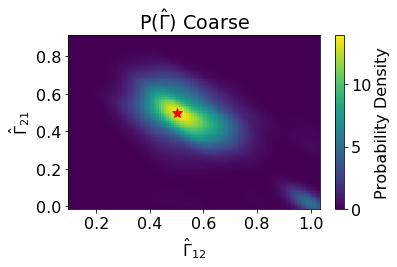

Sample Mean: [0.56463403 0.45067497]
Bias: [ 0.06463403 -0.04932503]
Empirical Standard Error: 
 [0.15626565 0.1550857 ]
Fischer Standard Error: 
 [nan nan]
pm: [nan nan]


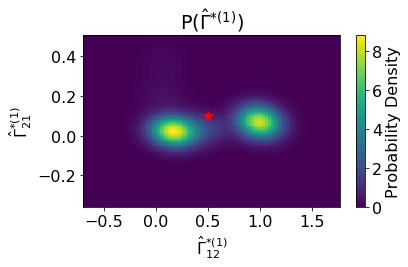

Sample Mean: [0.53711104 0.07442065]
Bias: [ 0.03711104 -0.02557935]
Empirical Standard Error: 
 [0.41004051 0.14484892]
Fischer Standard Error: 
 [nan nan]
pm: [nan nan]


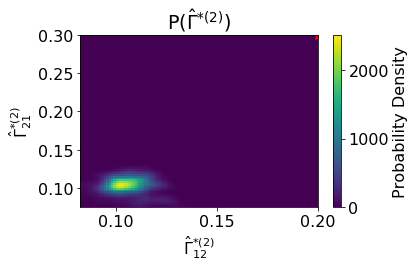

Sample Mean: [0.1057084  0.10237267]
Bias: [-0.0942916  -0.19762733]
Empirical Standard Error: 
 [0.00778402 0.00917843]
Fischer Standard Error: 
 [0.00761291 0.00782828]
pm: [0.00069686 0.0009093 ]


In [112]:
# make Gamma
if 'hhmm' in model:
    
    # Gamma Coarse
    G0 = [0.5,0.5]
    make_2d_kde_gamma(G0,hhmms,-1)
    
    # Gamma Fine 0
    G0 = [0.5,0.1]
    make_2d_kde_gamma(G0,hhmms,0)
    
    # Gamma Fine 1
    G0 = [0.2,0.3]
    make_2d_kde_gamma(G0,hhmms,1)
    
else:
    
    G0 = []
    make_2d_kde_gamma(G0,hhmms,0)

# Consider $\hat \Theta$ Coarse

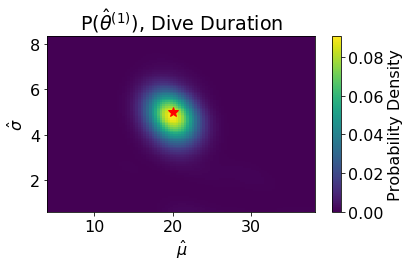

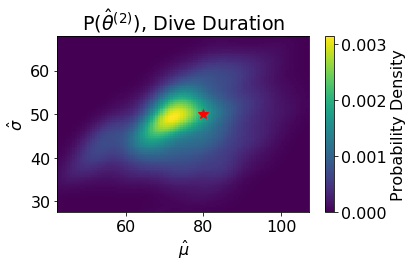

$\hat \mu$ sample mean: [21.1269219  74.86050653]
Bias: [ 1.1269219  -5.13949347]
Empirical Standard Error: [ 5.6933071 10.7792013]
Fischer Standard Error: [0.70165076 5.27486865]
pm: [       nan 1.26205571]

$\sigma$ sample mean: [ 4.48596745 47.79635628]
Bias: [-0.51403255 -2.20364372]
Empirical Standard Error: [1.29547901 6.73572021]
Fischer Standard Error: [0.55122648 4.75986676]
pm: [       nan 1.01078886]



/Users/evsi8432/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



In [113]:
# dive duration
if 'hhmm' in model:
    theta0 = {'mu':[20,80],'sig':[5,50],'corr':[0,0]}
    N = 2
else:
    sig = np.array([np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))])
    theta0 = {'mu':[50],'sig':sig,'corr':[0]}
    N = 1
    
make_2d_kde_theta('dive_duration',theta0,hhmms,-1,N,include_corr=False,feature_name='Dive Duration')

# Consider $\hat \Theta^*$ Fine

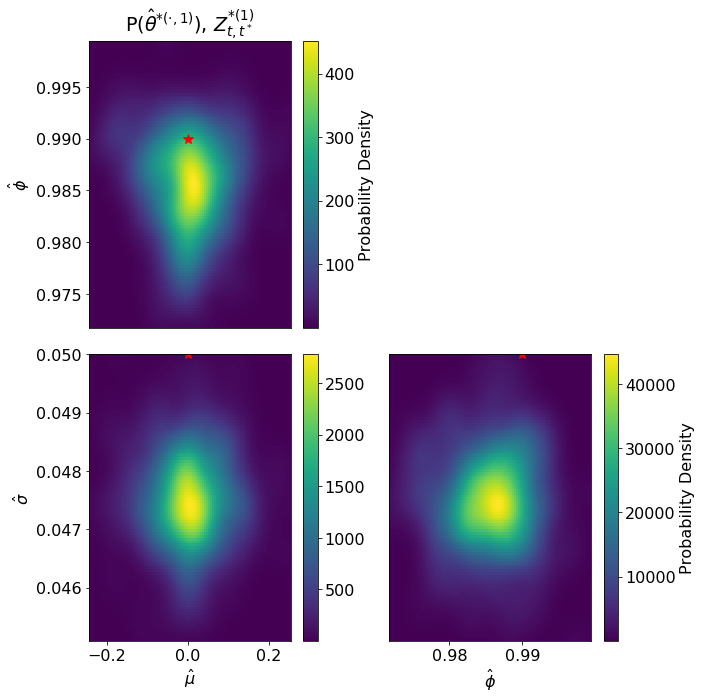

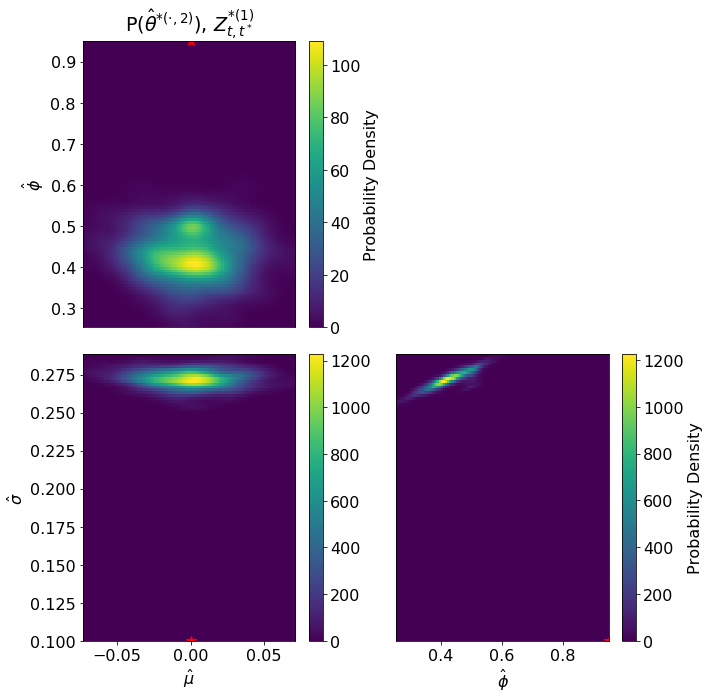

$\hat \mu$ sample mean: [ 0.00450628 -0.00105006]
Bias: [ 0.00450628 -0.00105006]
Empirical Standard Error: [0.08295099 0.02406883]
Fischer Standard Error: [0.07995843 0.00906741]
pm: [       nan 0.00102517]

$\sigma$ sample mean: [0.04750557 0.2724909 ]
Bias: [-0.00249443  0.1724909 ]
Empirical Standard Error: [0.00080585 0.0052425 ]
Fischer Standard Error: [0.00086191 0.00369392]
pm: [6.53969172e-05 1.47707813e-04]

$\rho$ sample mean: [0.98558771 0.42791319]
Bias: [-0.00441229 -0.52208681]
Empirical Standard Error: [0.00461273 0.05805878]
Fischer Standard Error: [0.00442893 0.01774933]
pm: [       nan 0.00102965]



/Users/evsi8432/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



In [114]:
# acceleration
N_star = 2
theta0 = {'mu':[0,0],'sig':[0.05,0.1],'corr':[0.99,0.95]}
dive_type = 0

if 'uncorr' in model:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='$Z_{t,t^*}^{*(1)}$')
else:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=True,feature_name='$Z_{t,t^*}^{*(1)}$')

if 'FV' in model:
    # FoVeDBA
    F_mus0 = np.array([sum([5.0/n for n in range(2,12)]),
                       300 + sum([5.0/n for n in range(4,12)])])
    F_sigs0 = np.sqrt(F_mus0)
    theta0 = {'mu':F_mus0,'sig':F_sigs0,'corr':[0,0]}
    dive_type = 0
    make_2d_kde_theta('FoVeDBA',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='$Z_{t,t^*}^{*(2)}$')

# Get percentage of time in right dive and subdive states

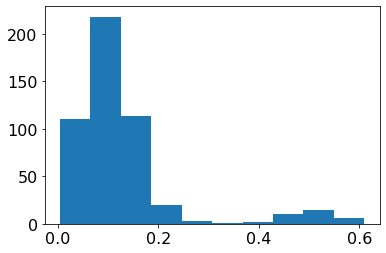

0.12963044389393943
0.11029000500447429


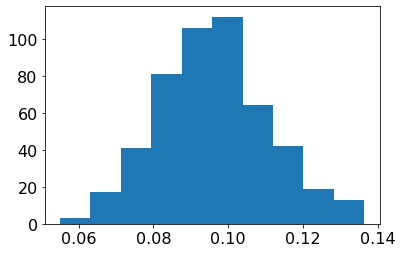

0.09609053001922771
0.014821184590274305


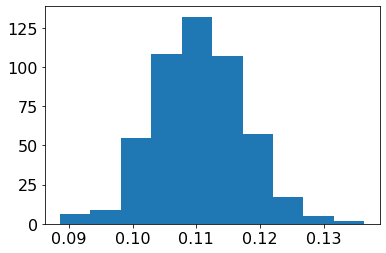

0.11050108996049311
0.007096147732944364


In [115]:
def acc(CM):
    return (CM[0,0]+CM[1,1])/np.sum(CM)

# get coarse accuracy
accuracies_coarse = [1.0-acc(hhmm.CM[0]) for hhmm in hhmms]
plt.hist(accuracies_coarse)
plt.show()
print(np.mean(accuracies_coarse))
print(np.std(accuracies_coarse))

accuracies_fine0 = [1.0-acc(hhmm.CM[1][0]) for hhmm in hhmms]
plt.hist(accuracies_fine0)
plt.show()
print(np.mean(accuracies_fine0))
print(np.std(accuracies_fine0))

accuracies_fine1 = [1.0-acc(hhmm.CM[1][1]) for hhmm in hhmms]
plt.hist(accuracies_fine1)
plt.show()
print(np.mean(accuracies_fine1))
print(np.std(accuracies_fine1))

# Get time to train

In [116]:
hhmm.theta

[{'dive_duration': {'mu': array([21.06785608, 84.93364158]),
   'sig': array([ 5.16685637, 61.16819909]),
   'corr': array([-10., -10.])}},
 [{'A': {'mu': array([0.11823041, 0.02473882]),
    'sig': array([0.04825279, 0.27294197]),
    'corr': array([ 4.26656288, -0.11465464])}},
  {'A': {'mu': array([0.11823041, 0.02473882]),
    'sig': array([0.04825279, 0.27294197]),
    'corr': array([ 4.26656288, -0.11465464])}}]]

257.5293454558575
81.57108142752396


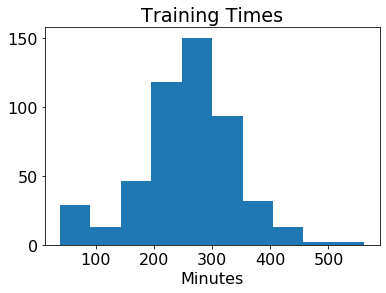

In [117]:
times = [hhmm.train_time/60.0 for hhmm in hhmms]
plt.hist(times)
plt.title('Training Times')
plt.xlabel('Minutes')
print(np.mean(times))
print(np.std(times))

# Make Table for Report

In [100]:
def make_table_dd():
    
    feature = 'dive_duration'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in range(1,501):
            try:
                file = '../Params/%s_%d_%d'%(model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                hhmms.append(hhmm)
            except:
                print('../Params/%s_%d_%d'%(model,0,dataset_num))
                
        # get estimates
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.mean(mus,0))
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.mean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        # get biases
        if model == 'hmm_FV':
            bias_mus.append(est_mus[-1] - np.array([50]))
            bias_sigs.append(est_sigs[-1] - np.array([np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))]))
        else:
            bias_mus.append(est_mus[-1] - np.array([20,80]))
            bias_sigs.append(est_sigs[-1] - np.array([5,50]))
            
        # get empirical standard errors
        ESE_mus.append(np.std(mus,0))
        ESE_sigs.append(np.std(sigs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[]
\label{table:dive_duration}
\centering
\caption{Estimates and standard errors of parameters for dive duration distribution for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.9}{
\begin{tabular}{ccccccc}
Model                      & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Estimate} & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}           \\ \hline
\multirow{4}{*}{CarHMM}    & \multirow{2}{*}{$\mu$}        & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\
                           & \multirow{2}{*}{$\sigma$}     & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\ \hline
\multirow{4}{*}{HHMM}      & \multirow{2}{*}{$\mu$}        & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & 2                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           & \multirow{2}{*}{$\sigma$}     & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & 2                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\ \hline
\multirow{4}{*}{CarHHMM 1} & \multirow{2}{*}{$\mu$}        & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & 2                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           & \multirow{2}{*}{$\sigma$}     & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & 2                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\ \hline
\multirow{4}{*}{CarHHMM 2} & \multirow{2}{*}{$\mu$}        & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & 2                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           & \multirow{2}{*}{$\sigma$}     & 1                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             \\
                           &                               & 2                             & $%.4f$                         & $%.4f$                     & $%.4f$                             & $%.4f \pm %.4f$                             
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_sigs[0][0],bias_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
        
    est_mus[1][0],bias_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
        
    est_mus[3][0],bias_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_mus[3][1],bias_mus[3][1],ESE_mus[3][1],FSE_mus[3][1],FSE_mus_SE[3][1],
    est_sigs[3][0],bias_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    est_sigs[3][1],bias_sigs[3][1],ESE_sigs[3][1],FSE_sigs[3][1],FSE_sigs_SE[3][1],
    )
    return table

print(make_table_dd())

../Params/hmm_FV_0_60
../Params/hmm_FV_0_246
../Params/hmm_FV_0_280
../Params/hmm_FV_0_314
../Params/hmm_FV_0_327
../Params/hmm_FV_0_428
../Params/hmm_FV_0_468
../Params/hhmm_FV_uncorr_0_21
../Params/hhmm_FV_uncorr_0_65
../Params/hhmm_V_0_83
../Params/hhmm_V_0_90
../Params/hhmm_FV_0_21
../Params/hhmm_FV_0_65

\begin{table}[]
\label{table:dive_duration}
\centering
\caption{Estimates and standard errors of parameters for dive duration distribution for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.9}{
\begin{tabular}{ccccccc}
Model                      & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Estimate} & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}           \\ \hline
\multirow{4}{*}{CarHMM}    & \multirow{2}{*}{$\mu$}        & 1                             & $49.9784$              

In [101]:
def make_table_A():
    
    feature = 'A'
    
    est_mus = []
    est_sigs = []
    est_corrs = []
    bias_mus = []
    bias_sigs = []
    bias_corrs = []
    ESE_mus = []
    ESE_sigs = []
    ESE_corrs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    FSE_corrs = []
    FSE_corrs_SE = []    
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in range(1,501):
            try:
                file = '../Params/%s_%d_%d'%(model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                hhmms.append(hhmm)
            except:
                print('../Params/%s_%d_%d'%(model,0,dataset_num))
                
        # get estimates
        mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.mean(mus,0))
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.mean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        corrs = expit(np.array([hhmm.theta[1][0][feature]['corr'] for hhmm in hhmms]))
        est_corrs.append(np.mean(corrs,0))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
        
        # get biases
        bias_mus.append(est_mus[-1] - np.array([0,0]))
        bias_sigs.append(est_sigs[-1] - np.array([0.05,0.1]))
        if model != 'hhmm_FV_uncorr':
            bias_corrs.append(est_corrs[-1] - np.array([0.99,0.95]))
        else:
            bias_corrs.append([])

        # get empirical standard errors
        ESE_mus.append(np.std(mus,0))
        ESE_sigs.append(np.std(sigs,0))
        ESE_corrs.append(np.std(corrs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
        FSE_corrs.append(np.nanmedian(corrs_SE,0))
        FSE_corrs_SE.append(iqr(corrs_SE,0,nan_policy='omit'))
        
    
    table = r'''
\begin{table}[]
\centering
\caption{Estimates and standard errors of parameters for $Z^{*(1)}_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate} & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}        \\ \hline
\multirow{6}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu$}        & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ 
                            & \multirow{2}{*}{$\phi$}       & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ \hline
\multirow{6}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu$}        & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ 
                            & \multirow{2}{*}{$\phi$}       & 1                             & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                             & ------                         & ------                     & ------                             & ------                                      \\ \hline
\multirow{6}{*}{CarHHMM}    & \multirow{2}{*}{$\mu$}        & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ 
                            & \multirow{2}{*}{$\phi$}       & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ \hline
\multirow{6}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu$}        & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ 
                            & \multirow{2}{*}{$\phi$}       & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ \hline
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_sigs[0][0],bias_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    est_corrs[0][0],bias_corrs[0][0],ESE_corrs[0][0],FSE_corrs[0][0],FSE_corrs_SE[0][0],
    est_corrs[0][1],bias_corrs[0][1],ESE_corrs[0][1],FSE_corrs[0][1],FSE_corrs_SE[0][1],
        
    est_mus[1][0],bias_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
    est_corrs[2][0],bias_corrs[2][0],ESE_corrs[2][0],FSE_corrs[2][0],FSE_corrs_SE[2][0],
    est_corrs[2][1],bias_corrs[2][1],ESE_corrs[2][1],FSE_corrs[2][1],FSE_corrs_SE[2][1],
        
    est_mus[3][0],bias_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_mus[3][1],bias_mus[3][1],ESE_mus[3][1],FSE_mus[3][1],FSE_mus_SE[3][1],
    est_sigs[3][0],bias_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    est_sigs[3][1],bias_sigs[3][1],ESE_sigs[3][1],FSE_sigs[3][1],FSE_sigs_SE[3][1],
    est_corrs[3][0],bias_corrs[3][0],ESE_corrs[3][0],FSE_corrs[3][0],FSE_corrs_SE[3][0],
    est_corrs[3][1],bias_corrs[3][1],ESE_corrs[3][1],FSE_corrs[3][1],FSE_corrs_SE[3][1],
    )
    return table

print(make_table_A())

../Params/hmm_FV_0_60
../Params/hmm_FV_0_246
../Params/hmm_FV_0_280
../Params/hmm_FV_0_314
../Params/hmm_FV_0_327
../Params/hmm_FV_0_428
../Params/hmm_FV_0_468
../Params/hhmm_FV_uncorr_0_21
../Params/hhmm_FV_uncorr_0_65


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2759: RuntimeWarning:

invalid value encountered in subtract



../Params/hhmm_V_0_83
../Params/hhmm_V_0_90
../Params/hhmm_FV_0_21
../Params/hhmm_FV_0_65

\begin{table}[]
\centering
\caption{Estimates and standard errors of parameters for $Z^{*(1)}_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate} & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}        \\ \hline
\multirow{6}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu$}        & 1                             & $0.01$                         & $0.01$                     & $0.25$                             & $0.13 \pm 0.12$                             \\
                            &                               & 2                             & $-0.00$                         & $-0

In [102]:
def make_table_FoVeDBA():
    
    F_mus0 = np.array([sum([5.0/n for n in range(2,12)]),
                       300 + sum([5.0/n for n in range(4,12)])])
    F_sigs0 = np.sqrt(F_mus0)
    
    feature = 'FoVeDBA'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in range(1,501):
            try:
                file = '../Params/%s_%d_%d'%(model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                hhmms.append(hhmm)
            except:
                print('../Params/%s_%d_%d'%(model,0,dataset_num))
                
        # get estimates
        if model != 'hhmm_V':
            mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
            est_mus.append(np.mean(mus,0))
            mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

            sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
            est_sigs.append(np.mean(sigs,0))
            sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

            # get biases
            bias_mus.append(est_mus[-1] - F_mus0)
            bias_sigs.append(est_sigs[-1] - F_sigs0)

            # get empirical standard errors
            ESE_mus.append(np.std(mus,0))
            ESE_sigs.append(np.std(sigs,0))

            # get Fischer Standard Errors
            FSE_mus.append(np.nanmedian(mus_SE,0))
            FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
            FSE_sigs.append(np.nanmedian(sigs_SE,0))
            FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}
\label{table:FoVeDBA}
\centering
\caption{Estimates and standard errors of parameters for $Z^{*(2)}_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate} & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}        \\ \hline
\multirow{4}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu$}        & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ \hline
\multirow{4}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu$}        & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\ \hline
\multirow{4}{*}{CarHHMM}    & \multirow{2}{*}{$\mu$}        & 1                             & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                             & ------                         & ------                     & ------                             & ------                                      \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                             & ------                         & ------                     & ------                             & ------                                      \\ \hline
\multirow{4}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu$}        & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             \\
                            &                               & 2                             & $%.2f$                         & $%.2f$                     & $%.2f$                             & $%.2f \pm %.2f$                             
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_sigs[0][0],bias_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    
    est_mus[1][0],bias_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1]
    )
    return table
print(make_table_FoVeDBA())

../Params/hmm_FV_0_60
../Params/hmm_FV_0_246
../Params/hmm_FV_0_280
../Params/hmm_FV_0_314
../Params/hmm_FV_0_327
../Params/hmm_FV_0_428
../Params/hmm_FV_0_468
../Params/hhmm_FV_uncorr_0_21
../Params/hhmm_FV_uncorr_0_65
../Params/hhmm_V_0_83
../Params/hhmm_V_0_90
../Params/hhmm_FV_0_21
../Params/hhmm_FV_0_65

\begin{table}
\label{table:FoVeDBA}
\centering
\caption{Estimates and standard errors of parameters for $Z^{*(2)}_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate} & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}        \\ \hline
\multirow{4}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu$}        & 1                             & $10.10$                         & $0.

In [103]:
def make_table_Gamma():
    
    feature = 'FoVeDBA'
    
    est_G0 = []
    est_G10 = []
    est_G11 = []
    bias_G0 = []
    bias_G10 = []
    bias_G11 = []
    ESE_G0 = []
    ESE_G10 = []
    ESE_G11 = []
    FSE_G0 = []
    FSE_G10 = []
    FSE_G11 = []
    FSE_G0_SE = []
    FSE_G10_SE = []
    FSE_G11_SE = []
    
    for model in ['hhmm_FV_uncorr','hmm_FV','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in range(1,501):
            try:
                file = '../Params/%s_%d_%d'%(model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                hhmms.append(hhmm)
            except:
                print('../Params/%s_%d_%d'%(model,0,dataset_num))
                
        G0 = []
        SE0 = []
        G10 = []
        SE10 = []
        G11 = []
        SE11 = []
        
        for hhmm in hhmms:
            if model != 'hmm_FV':
                
                # coarse
                ptm = HHMM.eta_2_ptm(hhmm.eta[0])
                SE = hhmm.SEs['Gamma_coarse']
                G0.append(np.array([ptm[0,1],ptm[1,0]]))
                SE0.append(np.array([SE[0,1],SE[1,0]]))
                
                # fine
                ptm = HHMM.eta_2_ptm(hhmm.eta[1][1])
                SE = hhmm.SEs['Gamma_fine'][1]
                G11.append(np.array([ptm[0,1],ptm[1,0]]))
                SE11.append(np.array([SE[0,1],SE[1,0]]))
            
            # fine for both HMM and HHMM
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][0])
            SE = hhmm.SEs['Gamma_fine'][0]
            G10.append(np.array([ptm[0,1],ptm[1,0]]))
            SE10.append(np.array([SE[0,1],SE[1,0]]))
            
            if model == 'hmm_FV':
                G0.append([])
                SE0.append([])
                G11.append([])
                SE11.append([])
            
        # get estimates
        est_G0.append(np.mean(G0,0))
        est_G10.append(np.mean(G10,0))
        est_G11.append(np.mean(G11,0))
        
        # get biases
        if model != 'hmm_FV':
            bias_G0.append(est_G0[-1] - np.array([0.5,0.5]))
            bias_G10.append(est_G10[-1] - np.array([0.5,0.1]))
            bias_G11.append(est_G11[-1] - np.array([0.2,0.3]))
        else:
            bias_G0.append([])
            bias_G10.append([])
            bias_G11.append([])            

        # get empirical standard errors
        ESE_G0.append(np.std(G0,0))
        ESE_G10.append(np.std(G10,0))
        ESE_G11.append(np.std(G11,0))
        
        # get Fischer Standard Errors
        FSE_G0.append(np.nanmedian(SE0,0))
        FSE_G0_SE.append(iqr(SE0,0,nan_policy='omit'))
        FSE_G10.append(np.nanmedian(SE10,0))
        FSE_G10_SE.append(iqr(SE10,0,nan_policy='omit'))
        FSE_G11.append(np.nanmedian(SE11,0))
        FSE_G11_SE.append(iqr(SE11,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[t]
\centering
\label{table:Gamma}
\caption{Estimates and standard errors of $\Gamma$ and $\Gamma^*$ for all four models. All reported values are averages except for the observed fisher SE, which is a median. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                        & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{6}{*}{HHMM-DFT}    & $\Gamma_{12}$                 & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma_{21}$                 & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\ \hline
\multirow{6}{*}{CarHMM-DFT}  & $\Gamma_{12}$                 & ------                         & ------                   & ------                           & ------                                      \\
                             & $\Gamma_{21}$                 & ------                         & ------                   & ------                           & ------                                      \\
                             & $\Gamma^{*(1)}_{12}$          & $%.2f$                         & ------                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.2f$                         & ------                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & ------                         & ------                   & ------                           & ------                                      \\
                             & $\Gamma^{*(2)}_{21}$          & ------                         & ------                   & ------                           & ------                                      \\ \hline
\multirow{6}{*}{CarHHMM}     & $\Gamma_{12}$                 & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma_{21}$                 & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\ \hline
\multirow{6}{*}{CarHHMM-DFT} & $\Gamma_{12}$                 & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma_{21}$                 & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.2f$                         & $%.2f$                   & $%.2f$                           & $%.2f \pm %.2f$                             \\ \hline

\end{tabular}
}
\end{table}
    ''' % (
    est_G0[0][0],bias_G0[0][0],ESE_G0[0][0],FSE_G0[0][0],FSE_G0_SE[0][0],
    est_G0[0][1],bias_G0[0][1],ESE_G0[0][1],FSE_G0[0][1],FSE_G0_SE[0][1],
    est_G10[0][0],bias_G10[0][0],ESE_G10[0][0],FSE_G10[0][0],FSE_G10_SE[0][0],
    est_G10[0][1],bias_G10[0][1],ESE_G10[0][1],FSE_G10[0][1],FSE_G10_SE[0][1],
    est_G11[0][0],bias_G11[0][0],ESE_G11[0][0],FSE_G11[0][0],FSE_G11_SE[0][0],
    est_G11[0][1],bias_G11[0][1],ESE_G11[0][1],FSE_G11[0][1],FSE_G11_SE[0][1],
        
    est_G10[1][0],ESE_G10[1][0],FSE_G10[1][0],FSE_G10_SE[1][0],
    est_G10[1][1],ESE_G10[1][1],FSE_G10[1][1],FSE_G10_SE[1][1],
    
    est_G0[2][0],bias_G0[2][0],ESE_G0[2][0],FSE_G0[2][0],FSE_G0_SE[2][0],
    est_G0[2][1],bias_G0[2][1],ESE_G0[2][1],FSE_G0[2][1],FSE_G0_SE[2][1],
    est_G10[2][0],bias_G10[2][0],ESE_G10[2][0],FSE_G10[2][0],FSE_G10_SE[2][0],
    est_G10[2][1],bias_G10[2][1],ESE_G10[2][1],FSE_G10[2][1],FSE_G10_SE[2][1],
    est_G11[2][0],bias_G11[2][0],ESE_G11[2][0],FSE_G11[2][0],FSE_G11_SE[2][0],
    est_G11[2][1],bias_G11[2][1],ESE_G11[2][1],FSE_G11[2][1],FSE_G11_SE[2][1],
        
    est_G0[3][0],bias_G0[3][0],ESE_G0[3][0],FSE_G0[3][0],FSE_G0_SE[3][0],
    est_G0[3][1],bias_G0[3][1],ESE_G0[3][1],FSE_G0[3][1],FSE_G0_SE[3][1],
    est_G10[3][0],bias_G10[3][0],ESE_G10[3][0],FSE_G10[3][0],FSE_G10_SE[3][0],
    est_G10[3][1],bias_G10[3][1],ESE_G10[3][1],FSE_G10[3][1],FSE_G10_SE[3][1],
    est_G11[3][0],bias_G11[3][0],ESE_G11[3][0],FSE_G11[3][0],FSE_G11_SE[3][0],
    est_G11[3][1],bias_G11[3][1],ESE_G11[3][1],FSE_G11[3][1],FSE_G11_SE[3][1],
    )
    return table

print(make_table_Gamma())

../Params/hhmm_FV_uncorr_0_21
../Params/hhmm_FV_uncorr_0_65
../Params/hmm_FV_0_60
../Params/hmm_FV_0_246
../Params/hmm_FV_0_280
../Params/hmm_FV_0_314
../Params/hmm_FV_0_327
../Params/hmm_FV_0_428
../Params/hmm_FV_0_468
../Params/hhmm_V_0_83
../Params/hhmm_V_0_90
../Params/hhmm_FV_0_21
../Params/hhmm_FV_0_65

\begin{table}[t]
\centering
\label{table:Gamma}
\caption{Estimates and standard errors of $\Gamma$ and $\Gamma^*$ for all four models. All reported values are averages except for the observed fisher SE, which is a median. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                        & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{6}{*}{HHMM-DFT}    & $\Gamma_{12}$                 & $0.50$                         & $0.00$                   & $0.08$                           & $0.08 \pm 0.01$               

In [104]:
def make_table_dive_acc():
    
    # coarse
    est_acc0 = []
    est_acc00 = []
    est_acc01 = []
    std_acc0 = []
    std_acc00 = []
    std_acc01 = []
    
    # fine
    est_acc1 = []
    est_acc100 = []
    est_acc101 = []
    est_acc110 = []
    est_acc111 = []
    
    std_acc1 = []
    std_acc100 = []
    std_acc101 = []
    std_acc110 = []
    std_acc111 = []
    
    # times
    mean_times = []
    std_times = []

    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in range(1,501):
            try:
                file = '../Params/%s_%d_%d'%(model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                hhmms.append(hhmm)
            except:
                print('../Params/%s_%d_%d'%(model,0,dataset_num))
            
            
        # Coarse
        acc0   = [(hhmm.CM[0][0,0]+hhmm.CM[0][1,1])/np.sum(hhmm.CM[0]) for hhmm in hhmms]
        acc00 = [hhmm.CM[0][0,0]/(hhmm.CM[0][0,0]+hhmm.CM[0][0,1]) for hhmm in hhmms]
        acc01 = [hhmm.CM[0][1,1]/(hhmm.CM[0][1,0]+hhmm.CM[0][1,1]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc00.append(np.mean(acc00,0))
        est_acc01.append(np.mean(acc01,0))
        est_acc0.append(np.mean(acc0,0))

        # get empirical standard errors
        std_acc00.append(np.std(acc00,0))
        std_acc01.append(np.std(acc01,0))
        std_acc0.append(np.std(acc0,0))
        
        
        # Fine
        acc1   = [(hhmm.CM[1][0][0,0]+hhmm.CM[1][0][1,1]+hhmm.CM[1][1][0,0]+hhmm.CM[1][1][1,1]) \
                 /np.sum(hhmm.CM[1][0] + hhmm.CM[1][1]) for hhmm in hhmms]
        acc100 = [hhmm.CM[1][0][0,0]/(hhmm.CM[1][0][0,0]+hhmm.CM[1][0][0,1]) for hhmm in hhmms]
        acc101 = [hhmm.CM[1][0][1,1]/(hhmm.CM[1][0][1,0]+hhmm.CM[1][0][1,1]) for hhmm in hhmms]
        acc110 = [hhmm.CM[1][1][0,0]/(hhmm.CM[1][1][0,0]+hhmm.CM[1][1][0,1]) for hhmm in hhmms]
        acc111 = [hhmm.CM[1][1][1,1]/(hhmm.CM[1][1][1,0]+hhmm.CM[1][1][1,1]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc100.append(np.mean(acc100,0))
        est_acc101.append(np.mean(acc101,0))
        est_acc110.append(np.mean(acc110,0))
        est_acc111.append(np.mean(acc111,0))
        est_acc1.append(np.mean(acc1,0))

        # get empirical standard errors
        std_acc100.append(np.std(acc100,0))
        std_acc101.append(np.std(acc101,0))
        std_acc110.append(np.std(acc110,0))
        std_acc111.append(np.std(acc111,0))
        std_acc1.append(np.std(acc1,0))
        
        # times
        mean_times.append(np.mean([hhmm.train_time/60.0 for hhmm in hhmms],0))
        std_times.append(np.std([hhmm.train_time/60.0 for hhmm in hhmms],0))
    
    table = r'''
\begin{table}[]
\label{table:accuracy}
\centering
\caption{Accuracies and run times for all models. All reported values are averages, and $\pm$ refers to the standard deviation.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Train Time (m)} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Dive Accuracy} & \multicolumn{1}{c}{Subdive Accuracy}  \\ \hline
\multirow{5}{*}{CarHMM-DFT} & \multirow{5}{*}{$%.2f \pm %.2f$}   & Both                          & Both                             & -------------                     & $%.2f \pm %.2f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{-------------}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{-------------}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ \hline 
\multirow{5}{*}{HHMM-DFT}   & \multirow{5}{*}{$%.2f \pm %.2f$}   & Both                          & Both                             & $%.2f \pm %.2f$                   & $%.2f \pm %.2f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{$%.2f\pm%.2f$}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{$%.2f\pm%.2f$}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ \hline
\multirow{5}{*}{CarHHMM}    & \multirow{5}{*}{$%.2f \pm %.2f$}   & Both                          & Both                             & $%.2f \pm %.2f$                   & $%.2f \pm %.2f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{$%.2f\pm%.2f$}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{$%.2f\pm%.2f$}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ \hline
\multirow{5}{*}{CarHHMM-DFT}& \multirow{5}{*}{$%.2f \pm %.2f$}   & Both                          & Both                             & $%.2f \pm %.2f$                   & $%.2f \pm %.2f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{$%.2f\pm%.2f$}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{$%.2f\pm%.2f$}    & $%.2f \pm %.2f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.2f \pm %.2f$                       \\ \hline
\end{tabular}
}
\end{table}
    ''' % (
        
        mean_times[0],std_times[0],
        #est_acc0[0],std_acc0[0],
        est_acc1[0],std_acc1[0],
        #est_acc00[0],std_acc00[0],
        est_acc100[0],std_acc100[0],
        est_acc101[0],std_acc101[0],
        #est_acc01[0],std_acc01[0],
        est_acc110[0],std_acc110[0],
        est_acc111[0],std_acc111[0],
        
        mean_times[1],std_times[1],
        est_acc0[1],std_acc0[1],
        est_acc1[1],std_acc1[1],
        est_acc00[1],std_acc00[1],
        est_acc100[1],std_acc100[1],
        est_acc101[1],std_acc101[1],
        est_acc01[1],std_acc01[1],
        est_acc110[1],std_acc110[1],
        est_acc111[1],std_acc111[1],
        
        mean_times[2],std_times[2],
        est_acc0[2],std_acc0[2],
        est_acc1[2],std_acc1[2],
        est_acc00[2],std_acc00[2],
        est_acc100[2],std_acc100[2],
        est_acc101[2],std_acc101[2],
        est_acc01[2],std_acc01[2],
        est_acc110[2],std_acc110[2],
        est_acc111[2],std_acc111[2],
        
        mean_times[3],std_times[3],
        est_acc0[3],std_acc0[3],
        est_acc1[3],std_acc1[3],
        est_acc00[3],std_acc00[3],
        est_acc100[3],std_acc100[3],
        est_acc101[3],std_acc101[3],
        est_acc01[3],std_acc01[3],
        est_acc110[3],std_acc110[3],
        est_acc111[3],std_acc111[3])
        
    return table
print(make_table_dive_acc())

../Params/hmm_FV_0_60
../Params/hmm_FV_0_246
../Params/hmm_FV_0_280
../Params/hmm_FV_0_314
../Params/hmm_FV_0_327
../Params/hmm_FV_0_428
../Params/hmm_FV_0_468
../Params/hhmm_FV_uncorr_0_21
../Params/hhmm_FV_uncorr_0_65
../Params/hhmm_V_0_83
../Params/hhmm_V_0_90
../Params/hhmm_FV_0_21
../Params/hhmm_FV_0_65

\begin{table}[]
\label{table:accuracy}
\centering
\caption{Accuracies and run times for all models. All reported values are averages, and $\pm$ refers to the standard deviation.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Train Time (m)} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Dive Accuracy} & \multicolumn{1}{c}{Subdive Accuracy}  \\ \hline
\multirow{5}{*}{CarHMM-DFT} & \multirow{5}{*}{$61.65 \pm 10.22$}   & Both                          & Both                             & -------------                     & $1.00 \pm 0.00$                       \\
                            &         